# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.3620994843085152 -2.771952885771233
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [35]:
# Data of the model
def model_input(state_size, lstm_size, batch_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    # GRU: Gated Recurrent Units
    gru = tf.nn.rnn_cell.GRUCell(lstm_size) # hidden size
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    # batch is supposed to be 1 in this case
    return states, actions, targetQs, reward, cell, initial_state

In [36]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [37]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [38]:
# # Generator/Controller: Generating/prediting the actions
# def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('generator', reuse=reuse):
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=states, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=action_size)        
#         #predictions = tf.nn.softmax(logits)

#         # return actions logits
#         return logits

In [39]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, batch_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        inputs_rnn = tf.reshape(inputs, [1, batch_size, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits

In [40]:
# # Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
# def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('discriminator', reuse=reuse):
#         # Fusion/merge states and actions/ SA/ SM
#         x_fused = tf.concat(axis=1, values=[states, actions])
        
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=1)        
#         #predictions = tf.nn.softmax(logits)

#         # return rewards logits
#         return logits

In [41]:
# RNN generator or sequence generator
def discriminator(states, actions, initial_state, cell, lstm_size, batch_size, reuse=False): 
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        inputs = tf.layers.dense(inputs=x_fused, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        inputs_rnn = tf.reshape(inputs, [1, batch_size, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=1)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits

In [42]:
def model_outputs(action_size, hidden_size, states, cell, batch_size, g_initial_state, d_initial_state):
    actions_logits, g_final_state = generator(states=states, num_classes=action_size, 
                                              cell=cell, initial_state=g_initial_state, 
                                              batch_size=batch_size, lstm_size=hidden_size)
    Qs_logits, d_final_state = discriminator(states=states, actions=actions_logits, 
                                             cell=cell, initial_state=d_initial_state, 
                                             batch_size=batch_size, lstm_size=hidden_size)
    return actions_logits, g_final_state, Qs_logits, d_final_state

In [43]:
def model_loss(action_size, hidden_size, 
               states, actions, targetQs, reward, 
               cell, g_initial_state, d_initial_state, batch_size):
    # G
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_logits, _ = generator(states=states, num_classes=action_size, 
                                  cell=cell, initial_state=g_initial_state, 
                                  batch_size=batch_size, lstm_size=hidden_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.reshape(rewards[-1], [1])])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    #Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    Qs_logits, _ = discriminator(states=states, actions=actions_logits, 
                                 cell=cell, initial_state=d_initial_state, 
                                 batch_size=batch_size, lstm_size=hidden_size)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return g_loss, d_loss, d_lossR, d_lossQ

In [44]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize RNN
    #g_grads=tf.gradients(g_loss, g_vars)
    #d_grads=tf.gradients(d_loss, d_vars)
    g_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(g_loss, g_vars), clip_norm=5) # usually around 1-5
    d_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(d_loss, d_vars), clip_norm=5) # usually around 1-5
    g_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(g_grads, g_vars))
    d_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(d_grads, d_vars))
    
    # # Optimize MLP & CNN
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    #     g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    #     d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [22]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward, cell, self.initial_state = model_input(
            state_size=state_size, batch_size=1, lstm_size=hidden_size)

        # Output of the Model: calculating the loss and forwad pass
        self.actions_logits, self.g_final_state, self.Qs_logits, self.d_final_state = model_outputs(
            num_classes=action_size, lstm_size=hidden_size, batch_size=batch_size,
            states=self.states, cell=cell, 
            g_initial_state=self.initial_state, d_initial_state=self.initial_state)
        
        # Create the Model: calculating the loss and forwad pass
        self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            num_classes=action_size, lstm_size=hidden_size, batch_size=batch_size,
            states=self.states, actions=self.actions, cell=cell,
            targetQs=self.targetQs, reward=self.reward,  
            g_initial_state=self.initial_state, d_initial_state=self.initial_state)
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [23]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [24]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [25]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [26]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR2.ckpt')

Episode:0 meanR:9.0000 rate:0.0180 gloss:-0.0220 dloss:0.6703 dlossR:0.6703 dlossQ:0.6929
Episode:1 meanR:16.5000 rate:0.0480 gloss:0.0869 dloss:0.7285 dlossR:0.7285 dlossQ:0.6916
Episode:2 meanR:18.6667 rate:0.0460 gloss:0.0845 dloss:0.7275 dlossR:0.7275 dlossQ:0.6917
Episode:3 meanR:19.7500 rate:0.0460 gloss:0.0573 dloss:0.7095 dlossR:0.7095 dlossQ:0.6927
Episode:4 meanR:19.0000 rate:0.0320 gloss:0.0344 dloss:0.7004 dlossR:0.7004 dlossQ:0.6930
Episode:5 meanR:19.1667 rate:0.0400 gloss:0.0125 dloss:0.6825 dlossR:0.6825 dlossQ:0.6934
Episode:6 meanR:18.8571 rate:0.0340 gloss:-0.0140 dloss:0.6672 dlossR:0.6672 dlossQ:0.6933
Episode:7 meanR:18.3750 rate:0.0300 gloss:-0.0452 dloss:0.6489 dlossR:0.6489 dlossQ:0.6927
Episode:8 meanR:17.7778 rate:0.0260 gloss:-0.0764 dloss:0.6297 dlossR:0.6297 dlossQ:0.6916
Episode:9 meanR:17.6000 rate:0.0320 gloss:-0.1003 dloss:0.6132 dlossR:0.6132 dlossQ:0.6904
Episode:10 meanR:17.2727 rate:0.0280 gloss:-0.1246 dloss:0.5999 dlossR:0.5999 dlossQ:0.6889
Epis

Episode:96 meanR:29.1134 rate:0.2860 gloss:-1.7412 dloss:0.8705 dlossR:0.8705 dlossQ:0.2706
Episode:97 meanR:29.9388 rate:0.2200 gloss:-1.8519 dloss:0.6977 dlossR:0.6977 dlossQ:0.2411
Episode:98 meanR:30.0606 rate:0.0840 gloss:-1.9969 dloss:0.3020 dlossR:0.3020 dlossQ:0.2071
Episode:99 meanR:30.1300 rate:0.0740 gloss:-1.9621 dloss:0.2701 dlossR:0.2701 dlossQ:0.2145
Episode:100 meanR:30.2900 rate:0.0500 gloss:-2.0865 dloss:0.2006 dlossR:0.2006 dlossQ:0.1899
Episode:101 meanR:30.1500 rate:0.0200 gloss:-2.4387 dloss:0.1073 dlossR:0.1073 dlossQ:0.1429
Episode:102 meanR:30.1700 rate:0.0500 gloss:-1.9268 dloss:0.2009 dlossR:0.2009 dlossQ:0.2251
Episode:103 meanR:30.1600 rate:0.0440 gloss:-1.8441 dloss:0.1838 dlossR:0.1838 dlossQ:0.2410
Episode:104 meanR:30.3100 rate:0.0620 gloss:-1.8612 dloss:0.2336 dlossR:0.2336 dlossQ:0.2366
Episode:105 meanR:30.4400 rate:0.0660 gloss:-1.8584 dloss:0.2449 dlossR:0.2449 dlossQ:0.2377
Episode:106 meanR:30.7100 rate:0.0880 gloss:-1.8241 dloss:0.3056 dlossR:0.

Episode:185 meanR:47.6400 rate:1.0000 gloss:-1.0617 dloss:2.6399 dlossR:2.6399 dlossQ:0.5298
Episode:186 meanR:50.2400 rate:0.5560 gloss:-1.3649 dloss:1.4995 dlossR:1.4995 dlossQ:0.3880
Episode:187 meanR:51.7400 rate:0.3540 gloss:-1.4661 dloss:0.9668 dlossR:0.9668 dlossQ:0.3486
Episode:188 meanR:53.0600 rate:0.3120 gloss:-1.4614 dloss:0.8503 dlossR:0.8503 dlossQ:0.3486
Episode:189 meanR:53.8800 rate:0.2040 gloss:-1.5123 dloss:0.5808 dlossR:0.5808 dlossQ:0.3318
Episode:190 meanR:54.9600 rate:0.2480 gloss:-1.4477 dloss:0.6791 dlossR:0.6791 dlossQ:0.3503
Episode:191 meanR:55.5000 rate:0.1280 gloss:-1.4266 dloss:0.3882 dlossR:0.3882 dlossQ:0.3552
Episode:192 meanR:55.6100 rate:0.0400 gloss:-1.5991 dloss:0.1884 dlossR:0.1884 dlossQ:0.3070
Episode:193 meanR:55.7900 rate:0.0580 gloss:-1.4846 dloss:0.2366 dlossR:0.2366 dlossQ:0.3401
Episode:194 meanR:55.9200 rate:0.0460 gloss:-1.5145 dloss:0.2094 dlossR:0.2094 dlossQ:0.3319
Episode:195 meanR:56.0200 rate:0.0740 gloss:-1.4150 dloss:0.2732 dloss

Episode:285 meanR:45.8800 rate:0.0280 gloss:-2.0701 dloss:0.1351 dlossR:0.1351 dlossQ:0.1948
Episode:286 meanR:43.2400 rate:0.0280 gloss:-2.0976 dloss:0.1339 dlossR:0.1339 dlossQ:0.1892
Episode:287 meanR:41.5900 rate:0.0240 gloss:-2.2099 dloss:0.1205 dlossR:0.1205 dlossQ:0.1695
Episode:288 meanR:40.1500 rate:0.0240 gloss:-2.2831 dloss:0.1200 dlossR:0.1200 dlossQ:0.1588
Episode:289 meanR:39.2300 rate:0.0200 gloss:-2.3082 dloss:0.1089 dlossR:0.1089 dlossQ:0.1581
Episode:290 meanR:38.1000 rate:0.0220 gloss:-2.3602 dloss:0.1143 dlossR:0.1143 dlossQ:0.1506
Episode:291 meanR:37.5900 rate:0.0260 gloss:-2.1011 dloss:0.1284 dlossR:0.1284 dlossQ:0.1915
Episode:292 meanR:37.6000 rate:0.0420 gloss:-1.9289 dloss:0.1779 dlossR:0.1779 dlossQ:0.2265
Episode:293 meanR:37.5900 rate:0.0560 gloss:-1.8102 dloss:0.2184 dlossR:0.2184 dlossQ:0.2545
Episode:294 meanR:37.8500 rate:0.0980 gloss:-1.6909 dloss:0.3290 dlossR:0.3290 dlossQ:0.2851
Episode:295 meanR:37.9800 rate:0.1000 gloss:-1.6351 dloss:0.3300 dloss

Episode:462 meanR:28.4400 rate:0.0440 gloss:-1.8615 dloss:0.1855 dlossR:0.1855 dlossQ:0.2430
Episode:463 meanR:28.5600 rate:0.0460 gloss:-1.8113 dloss:0.1913 dlossR:0.1913 dlossQ:0.2534
Episode:464 meanR:28.7800 rate:0.0680 gloss:-1.6955 dloss:0.2495 dlossR:0.2495 dlossQ:0.2804
Episode:465 meanR:28.8000 rate:0.1120 gloss:-1.8239 dloss:0.3724 dlossR:0.3724 dlossQ:0.2490
Episode:466 meanR:28.6200 rate:0.0680 gloss:-1.9059 dloss:0.2514 dlossR:0.2514 dlossQ:0.2300
Episode:467 meanR:28.4900 rate:0.0600 gloss:-1.9130 dloss:0.2283 dlossR:0.2283 dlossQ:0.2279
Episode:468 meanR:28.3600 rate:0.0740 gloss:-1.8964 dloss:0.2678 dlossR:0.2678 dlossQ:0.2320
Episode:469 meanR:28.4900 rate:0.0620 gloss:-1.9173 dloss:0.2339 dlossR:0.2339 dlossQ:0.2272
Episode:470 meanR:28.4900 rate:0.0340 gloss:-2.0544 dloss:0.1517 dlossR:0.1517 dlossQ:0.1989
Episode:471 meanR:28.4400 rate:0.0300 gloss:-2.0764 dloss:0.1396 dlossR:0.1396 dlossQ:0.1947
Episode:472 meanR:28.4800 rate:0.0480 gloss:-1.9974 dloss:0.1937 dloss

Episode:554 meanR:33.3400 rate:0.1040 gloss:-1.4285 dloss:0.3349 dlossR:0.3349 dlossQ:0.3549
Episode:555 meanR:33.7000 rate:0.1060 gloss:-1.3999 dloss:0.3391 dlossR:0.3391 dlossQ:0.3634
Episode:556 meanR:33.9600 rate:0.0940 gloss:-1.4367 dloss:0.3133 dlossR:0.3133 dlossQ:0.3526
Episode:557 meanR:34.1600 rate:0.0900 gloss:-1.4519 dloss:0.3044 dlossR:0.3044 dlossQ:0.3481
Episode:558 meanR:34.2300 rate:0.0520 gloss:-1.5419 dloss:0.2164 dlossR:0.2164 dlossQ:0.3218
Episode:559 meanR:34.3500 rate:0.0640 gloss:-1.5589 dloss:0.2427 dlossR:0.2427 dlossQ:0.3170
Episode:560 meanR:34.4000 rate:0.0460 gloss:-1.5762 dloss:0.2004 dlossR:0.2004 dlossQ:0.3119
Episode:561 meanR:34.4400 rate:0.0340 gloss:-1.6114 dloss:0.1705 dlossR:0.1705 dlossQ:0.3023
Episode:562 meanR:34.4800 rate:0.0520 gloss:-1.6251 dloss:0.2120 dlossR:0.2120 dlossQ:0.2990
Episode:563 meanR:34.4500 rate:0.0400 gloss:-1.6408 dloss:0.1826 dlossR:0.1826 dlossQ:0.2944
Episode:564 meanR:34.3400 rate:0.0460 gloss:-1.7103 dloss:0.1941 dloss

Episode:645 meanR:32.7400 rate:0.0220 gloss:-2.2159 dloss:0.1174 dlossR:0.1174 dlossQ:0.1750
Episode:646 meanR:32.9300 rate:0.0620 gloss:-1.8167 dloss:0.2354 dlossR:0.2354 dlossQ:0.2531
Episode:647 meanR:32.9500 rate:0.0220 gloss:-1.9848 dloss:0.1222 dlossR:0.1222 dlossQ:0.2140
Episode:648 meanR:32.6600 rate:0.0200 gloss:-2.0131 dloss:0.1160 dlossR:0.1160 dlossQ:0.2087
Episode:649 meanR:32.3100 rate:0.0260 gloss:-1.9575 dloss:0.1337 dlossR:0.1337 dlossQ:0.2189
Episode:650 meanR:31.3300 rate:0.0200 gloss:-2.0113 dloss:0.1158 dlossR:0.1158 dlossQ:0.2091
Episode:651 meanR:30.6600 rate:0.0200 gloss:-2.0143 dloss:0.1153 dlossR:0.1153 dlossQ:0.2084
Episode:652 meanR:30.5900 rate:0.1640 gloss:-1.6311 dloss:0.4945 dlossR:0.4945 dlossQ:0.2997
Episode:653 meanR:30.2600 rate:0.0800 gloss:-1.6511 dloss:0.2822 dlossR:0.2822 dlossQ:0.2945
Episode:654 meanR:29.8800 rate:0.0280 gloss:-1.8371 dloss:0.1426 dlossR:0.1426 dlossQ:0.2459
Episode:655 meanR:29.4500 rate:0.0200 gloss:-2.3855 dloss:0.1105 dloss

Episode:737 meanR:47.4500 rate:0.0620 gloss:-1.3185 dloss:0.2554 dlossR:0.2554 dlossQ:0.3894
Episode:738 meanR:47.2700 rate:0.1020 gloss:-1.3574 dloss:0.3337 dlossR:0.3337 dlossQ:0.3790
Episode:739 meanR:46.2600 rate:0.0220 gloss:-2.1043 dloss:0.1258 dlossR:0.1258 dlossQ:0.1988
Episode:740 meanR:46.8100 rate:0.1920 gloss:-1.1194 dloss:0.5046 dlossR:0.5046 dlossQ:0.4547
Episode:741 meanR:47.6000 rate:0.2140 gloss:-1.0881 dloss:0.5418 dlossR:0.5418 dlossQ:0.4649
Episode:742 meanR:48.4100 rate:0.1840 gloss:-1.1019 dloss:0.4870 dlossR:0.4870 dlossQ:0.4595
Episode:743 meanR:49.3800 rate:0.2160 gloss:-1.0938 dloss:0.5460 dlossR:0.5460 dlossQ:0.4631
Episode:744 meanR:50.2300 rate:0.1920 gloss:-1.0953 dloss:0.5009 dlossR:0.5009 dlossQ:0.4619
Episode:745 meanR:51.3300 rate:0.2420 gloss:-1.0623 dloss:0.5903 dlossR:0.5903 dlossQ:0.4738
Episode:746 meanR:52.0400 rate:0.2040 gloss:-1.0681 dloss:0.5214 dlossR:0.5214 dlossQ:0.4710
Episode:747 meanR:52.9900 rate:0.2120 gloss:-1.0394 dloss:0.5335 dloss

Episode:830 meanR:49.2800 rate:0.0340 gloss:-1.9988 dloss:0.1555 dlossR:0.1555 dlossQ:0.2145
Episode:831 meanR:49.0500 rate:0.0620 gloss:-1.7275 dloss:0.2361 dlossR:0.2361 dlossQ:0.2767
Episode:832 meanR:49.0600 rate:0.0740 gloss:-1.6178 dloss:0.2673 dlossR:0.2673 dlossQ:0.3050
Episode:833 meanR:49.3400 rate:0.1080 gloss:-1.5149 dloss:0.3462 dlossR:0.3462 dlossQ:0.3317
Episode:834 meanR:49.8900 rate:0.1440 gloss:-1.5800 dloss:0.4356 dlossR:0.4356 dlossQ:0.3104
Episode:835 meanR:50.4300 rate:0.1420 gloss:-1.3228 dloss:0.4148 dlossR:0.4148 dlossQ:0.3888
Episode:836 meanR:50.6200 rate:0.0580 gloss:-1.6487 dloss:0.2250 dlossR:0.2250 dlossQ:0.2911
Episode:837 meanR:50.7300 rate:0.0840 gloss:-1.5839 dloss:0.2890 dlossR:0.2890 dlossQ:0.3096
Episode:838 meanR:50.5500 rate:0.0660 gloss:-1.6348 dloss:0.2451 dlossR:0.2451 dlossQ:0.2961
Episode:839 meanR:50.6700 rate:0.0460 gloss:-1.7137 dloss:0.1935 dlossR:0.1935 dlossQ:0.2754
Episode:840 meanR:49.9300 rate:0.0440 gloss:-1.7331 dloss:0.1878 dloss

Episode:920 meanR:43.7500 rate:0.1900 gloss:-1.3670 dloss:0.5286 dlossR:0.5286 dlossQ:0.3796
Episode:921 meanR:44.7200 rate:0.2900 gloss:-1.3296 dloss:0.7536 dlossR:0.7536 dlossQ:0.3924
Episode:922 meanR:45.0400 rate:0.1160 gloss:-1.5115 dloss:0.3682 dlossR:0.3682 dlossQ:0.3358
Episode:923 meanR:45.4800 rate:0.1400 gloss:-1.5109 dloss:0.4258 dlossR:0.4258 dlossQ:0.3376
Episode:924 meanR:46.3300 rate:0.2280 gloss:-1.4294 dloss:0.6256 dlossR:0.6256 dlossQ:0.3606
Episode:925 meanR:46.8300 rate:0.1600 gloss:-1.4913 dloss:0.4691 dlossR:0.4691 dlossQ:0.3403
Episode:926 meanR:47.8600 rate:0.2260 gloss:-1.3774 dloss:0.6090 dlossR:0.6090 dlossQ:0.3739
Episode:927 meanR:48.1500 rate:0.0860 gloss:-1.4909 dloss:0.2995 dlossR:0.2995 dlossQ:0.3416
Episode:928 meanR:48.4900 rate:0.0880 gloss:-1.4571 dloss:0.3048 dlossR:0.3048 dlossQ:0.3515
Episode:929 meanR:48.9200 rate:0.1080 gloss:-1.4452 dloss:0.3460 dlossR:0.3460 dlossQ:0.3517
Episode:930 meanR:48.8400 rate:0.0180 gloss:-1.9401 dloss:0.1215 dloss

Episode:1011 meanR:43.8300 rate:0.1740 gloss:-1.3515 dloss:0.4865 dlossR:0.4865 dlossQ:0.3802
Episode:1012 meanR:44.5800 rate:0.2680 gloss:-1.6900 dloss:0.8002 dlossR:0.8002 dlossQ:0.2906
Episode:1013 meanR:44.5700 rate:0.1240 gloss:-1.9636 dloss:0.4245 dlossR:0.4245 dlossQ:0.2251
Episode:1014 meanR:44.9200 rate:0.1000 gloss:-1.9899 dloss:0.3517 dlossR:0.3517 dlossQ:0.2159
Episode:1015 meanR:44.9400 rate:0.0380 gloss:-1.8963 dloss:0.1671 dlossR:0.1671 dlossQ:0.2324
Episode:1016 meanR:44.9900 rate:0.0380 gloss:-1.9407 dloss:0.1659 dlossR:0.1659 dlossQ:0.2221
Episode:1017 meanR:45.0200 rate:0.0300 gloss:-1.9700 dloss:0.1432 dlossR:0.1432 dlossQ:0.2162
Episode:1018 meanR:44.4900 rate:0.0320 gloss:-1.9682 dloss:0.1491 dlossR:0.1491 dlossQ:0.2169
Episode:1019 meanR:43.8600 rate:0.0300 gloss:-1.9442 dloss:0.1439 dlossR:0.1439 dlossQ:0.2216
Episode:1020 meanR:43.0900 rate:0.0360 gloss:-1.8782 dloss:0.1630 dlossR:0.1630 dlossQ:0.2372
Episode:1021 meanR:41.8400 rate:0.0400 gloss:-1.7821 dloss:0

Episode:1102 meanR:45.7900 rate:0.1680 gloss:-1.4102 dloss:0.4770 dlossR:0.4770 dlossQ:0.3608
Episode:1103 meanR:46.9600 rate:0.2580 gloss:-1.1213 dloss:0.6324 dlossR:0.6324 dlossQ:0.4557
Episode:1104 meanR:47.3000 rate:0.0980 gloss:-1.5012 dloss:0.3212 dlossR:0.3212 dlossQ:0.3327
Episode:1105 meanR:47.7300 rate:0.1060 gloss:-1.4836 dloss:0.3393 dlossR:0.3393 dlossQ:0.3379
Episode:1106 meanR:48.2100 rate:0.1180 gloss:-1.4595 dloss:0.3660 dlossR:0.3660 dlossQ:0.3451
Episode:1107 meanR:48.5900 rate:0.0980 gloss:-1.4716 dloss:0.3211 dlossR:0.3211 dlossQ:0.3412
Episode:1108 meanR:49.8200 rate:0.2780 gloss:-1.0275 dloss:0.6552 dlossR:0.6552 dlossQ:0.4856
Episode:1109 meanR:50.1100 rate:0.0780 gloss:-1.4953 dloss:0.2762 dlossR:0.2762 dlossQ:0.3343
Episode:1110 meanR:50.1600 rate:0.1100 gloss:-1.4149 dloss:0.3478 dlossR:0.3478 dlossQ:0.3585
Episode:1111 meanR:49.6000 rate:0.0620 gloss:-1.5122 dloss:0.2404 dlossR:0.2404 dlossQ:0.3297
Episode:1112 meanR:48.4900 rate:0.0460 gloss:-1.5559 dloss:0

Episode:1192 meanR:31.5300 rate:0.0560 gloss:-1.6355 dloss:0.2240 dlossR:0.2240 dlossQ:0.3005
Episode:1193 meanR:31.4900 rate:0.0500 gloss:-1.7797 dloss:0.2050 dlossR:0.2050 dlossQ:0.2640
Episode:1194 meanR:31.5300 rate:0.0940 gloss:-1.6714 dloss:0.3199 dlossR:0.3199 dlossQ:0.2938
Episode:1195 meanR:31.3500 rate:0.0260 gloss:-2.1614 dloss:0.1348 dlossR:0.1348 dlossQ:0.1946
Episode:1196 meanR:31.3400 rate:0.0680 gloss:-1.6931 dloss:0.2544 dlossR:0.2544 dlossQ:0.2878
Episode:1197 meanR:31.6500 rate:0.0860 gloss:-1.7820 dloss:0.3014 dlossR:0.3014 dlossQ:0.2650
Episode:1198 meanR:31.9500 rate:0.0800 gloss:-1.7191 dloss:0.2836 dlossR:0.2836 dlossQ:0.2797
Episode:1199 meanR:31.5900 rate:0.0880 gloss:-1.7951 dloss:0.3067 dlossR:0.3067 dlossQ:0.2613


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

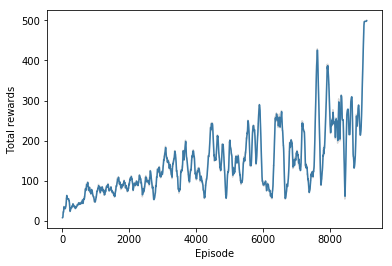

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

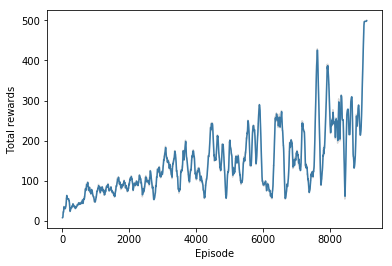

In [27]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

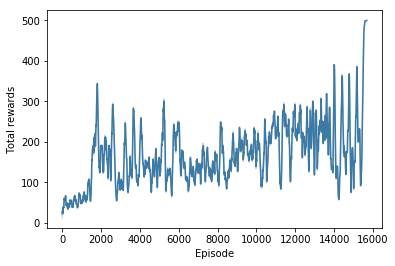

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

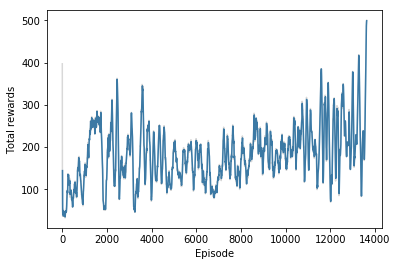

In [32]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

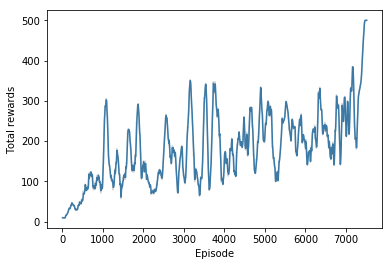

Text(0,0.5,'G losses')

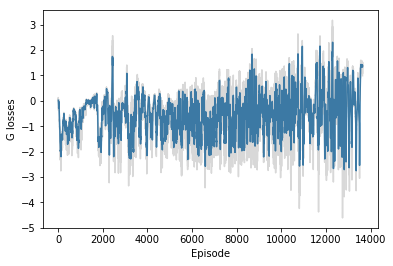

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

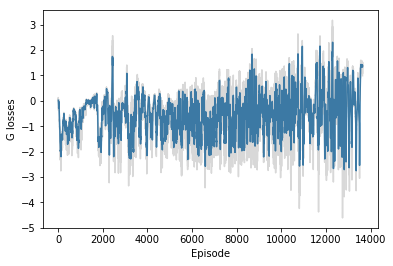

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

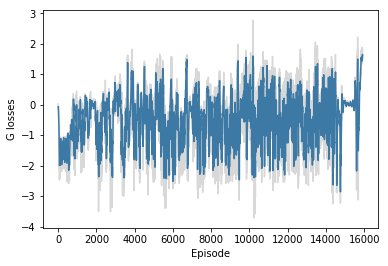
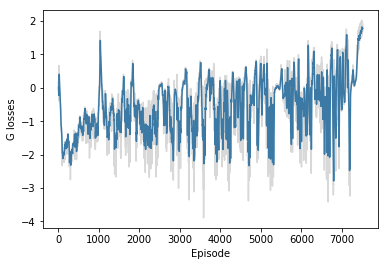

Text(0,0.5,'D losses')

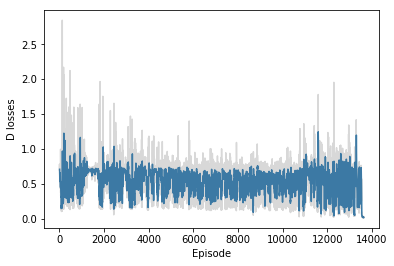

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

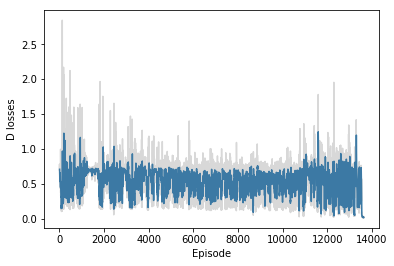

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

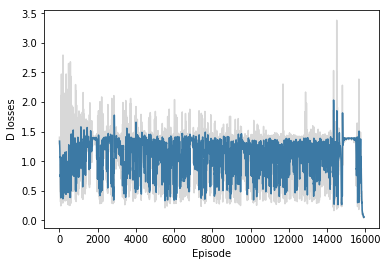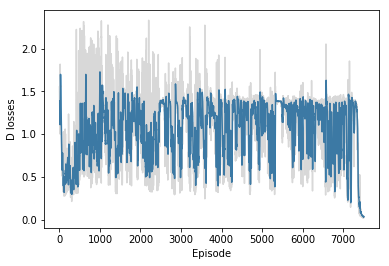

Text(0,0.5,'D losses R')

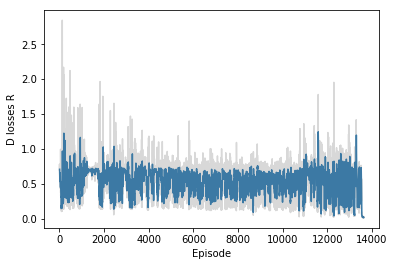

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

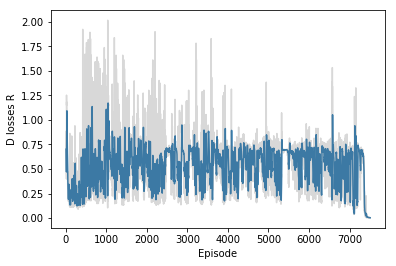

In [32]:
# eps, arr = np.array(d_lossR_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

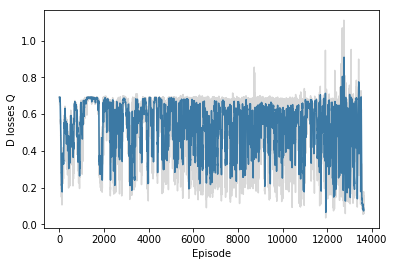

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

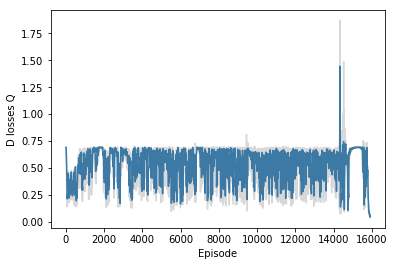

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

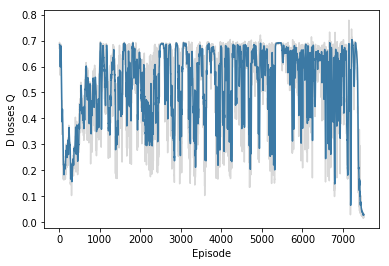

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.